In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [2]:
data = pd.read_csv('E:\study\Мисис\Хакатон 3 РЖД\statistics-07-20-upd.csv', sep = ';')

# Анализ данных

In [3]:
data.head()

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,...,operation_st_id,operation_train,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto
0,NaN,NaN,62827035,984700.0,NaN,NaN,NaN,2.0,81.0,2020-07-16 03:40:00,...,2.000039e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,62827035,862201.0,20.0,NaN,421034.0,NaN,18.0,2020-07-16 14:10:00,...,2.002026e+09,NaN,93149858.0,60.0,NaN,68398528.0,NaN,NaN,249.0,NaN
2,NaN,NaN,62827316,863007.0,NaN,NaN,NaN,2.0,80.0,2020-07-16 14:50:00,...,2.001933e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,62827381,862108.0,NaN,NaN,NaN,2.0,80.0,2020-07-16 14:16:00,...,2.001931e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,62845730,887904.0,20.0,NaN,421034.0,NaN,19.0,2020-07-16 15:15:00,...,2.000039e+09,NaN,81195103.0,60.0,NaN,52682351.0,NaN,NaN,248.0,NaN


In [4]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])

In [5]:
def find_duplicates_by_columns(df):  # функция для поиска дубликатов по столбцам
    duplicates = []
    column = []
    for i in df.columns:
        duplicates.append(df[i].duplicated().sum())
        column.append(i)
    duplicates = pd.Series(duplicates) 
    column = pd.Series(column) 
    return pd.concat([column, duplicates], axis = 1,
                     keys = ['column', 'duplicates']).sort_values(by = 'duplicates',ascending = False).head(40)

In [6]:
missing_data(data)

,Total,Percent
danger,4077929,97.327249
adm,3085197,73.633880
tare_weight,3085197,73.633880
rod_train,2623663,62.618526
weight_brutto,2623318,62.610292
ssp_station_id,2255185,53.824123
operation_train,2222194,53.036732
index_train,2222193,53.036708
ssp_station_esr,2222193,53.036708
gruz,1779461,42.470098


In [7]:
find_duplicates_by_columns(data)

,column,duplicates
5,danger,4189913
7,loaded,4189911
14,rodvag,4189903
4,adm,4189901
12,operation_train,4189901
8,operation_car,4189894
15,rod_train,4189887
1,length,4189838
19,tare_weight,4189580
11,operation_st_id,4189170


# Предобработка

In [8]:
data.operation_date = pd.to_datetime(data.operation_date, format='%Y-%m-%d %H:%M')
data.operation_date

0         2020-07-16 03:40:00
1         2020-07-16 14:10:00
2         2020-07-16 14:50:00
3         2020-07-16 14:16:00
4         2020-07-16 15:15:00
                  ...        
4189910   2020-07-16 03:29:00
4189911   2020-07-16 03:30:00
4189912   2020-07-15 20:00:00
4189913   2020-07-16 02:37:00
4189914   2020-07-16 04:28:00
Name: operation_date, Length: 4189915, dtype: datetime64[ns]

In [9]:
data.danger = data.danger.fillna(0)

In [10]:
data.shape

(4189915, 21)

In [11]:
data.danger = data.danger.fillna(0)
data = data.sort_values(by = ['operation_date'], ascending = True)
data = data.reset_index(drop = True)

#### Ряды будут выделяться так :

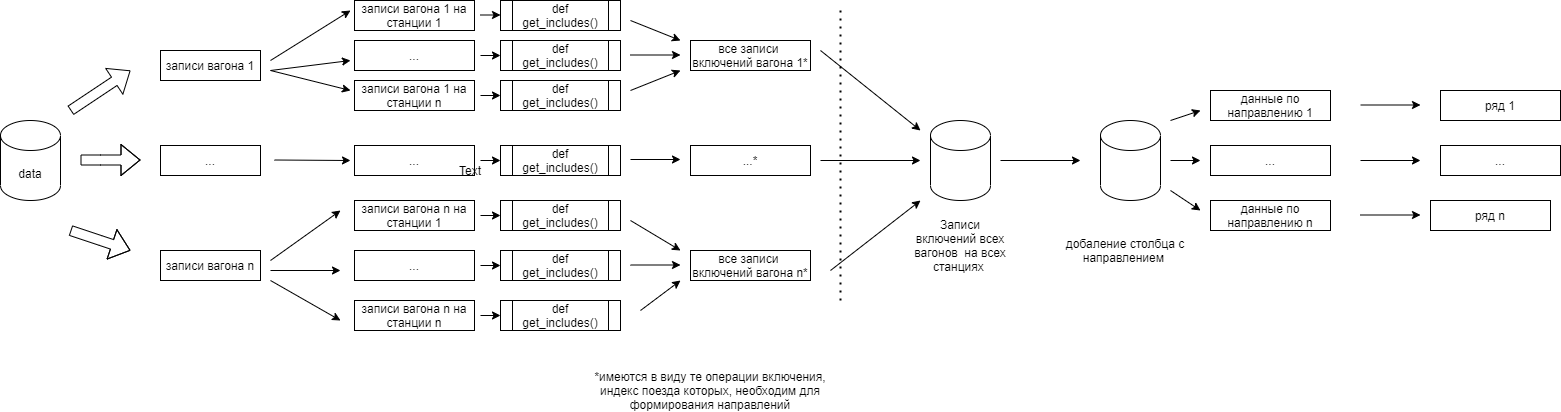

# Получение всех подходящих условию опрераций включения вагонов в поезд для всех вагонов на всех станциях

In [12]:
# возвращает список датафреймов со всеми операцифми по каждому уникальному вагону 
def get_data_cars(data):
    
    data_cars_stack = [] 
    cars_numbers = data['car_number'].unique()
    print('Собираются датафреймы для каждого из {} уникальных вагонов :'.format(len(cars_numbers)))
    for cars_number in tqdm(cars_numbers):
        car_df = pd.DataFrame(data[data.car_number == cars_number].sort_values(by = ['operation_date'], ascending = True))
        car_df = car_df.reset_index(drop=True)
        data_cars_stack.append(car_df)
        
    return data_cars_stack #список датафрейфмов

In [13]:
# принимает датафрейм со всеми операцифми по каждому уникальному вагону
# возвращат список датафреймов, где каждый элемент - датафрейм одного уникального вагона на одной уникальной станции
def split_data_car_into_stations(data_car):  
    
    data_cars_st_stack = []
    st_esrS = data_car.operation_st_esr.unique()
    for st_esr in st_esrS:
        car_st_df = pd.DataFrame(data_car[data_car.operation_st_esr == st_esr].sort_values(by = ['operation_date'], ascending = True))
        car_st_df = car_st_df.reset_index(drop = True)
        data_cars_st_stack.append(car_st_df)
    
    return data_cars_st_stack # стек датафреймов одного вагона на разных станциях

Для каждого датафрейма с данными об уникальном вагоне на уникальной станции за все время, ищутся operation_train in ([ 2., 62., 22., 42.] ), идем по наблюдениям назад по времени и ищем первую встречную operation_car == 4, идем по наблюдениям назад по времени до предыдущего отправления в operation_train и если в интервале есть операции погрузки/выгрузки до текущей операции включения, значит данную операцию включения в поезд берем, если же в интервале нет операций погрузки выгрузки, то перехожим к предыдущей операции включения и проверяем её интервал до отправления на наличие операций погрузки/выгрузки. Из нескольких подходящих вышеуказанному условию наблюдений внутри каждого интервала (между отправлениями поезда), в которых операция с вагоном == операция включения в поезд, берем только одну последнюю операцию включения в поезд.


In [2]:
# принимает датафрейм с данными об уникальном вагоне на уникальной станции за все время
# возвращает датафрейм с операциями включения, подходящими условию, для одного уникального вагона на одной уникальной станции
def get_includes(data_car_st):
    
    buffer = []
    for i in reversed(range(len(data_car_st))): # идем по последнним наблюдениям к боллее старым для каждого датафрейма с данными об уникальном вагоне на уникальной станции за все время
        if (data_car_st.loc[i, 'operation_train'] in (2, 62, 22, 42)) & (i>0): # находим операцию отправления поезда
            j = i-1
            valid_inclusion_operations_indexes = [] #подходящие вагоны с операцией включения
            while (data_car_st.loc[j, 'operation_train'] not in (2, 62, 22, 42)) & (j>0):# ограничиваем поиск операции включения предыдущей операцией отправления поезда
                if data_car_st.loc[j, 'operation_car'] == 4:  #находим операции включения в поезд перед последней операцией отправления
                    flag = False
                    k = j-1
                    while (data_car_st.loc[k, 'operation_train'] not in (2, 62, 22, 42)) & (k>=0): #ограничиваем интервал до предыдущей операции отправления поезда
                        if data_car_st.loc[k, 'operation_car'] in (10,11,13,14,15,17,18,19,20,21,23,24,25,28,29):#проверяем наличие хоть одной операции разгрузки/погрузки
                            flag = True 
                        if k > 0:
                            k -= 1                # смотрим предыдущие записиси в интревале
                        else:
                            break  
                    if flag == True:
                        valid_inclusion_operations_indexes.append(j)
                j-=1
                
            if valid_inclusion_operations_indexes : buffer.append(data_car_st.iloc[valid_inclusion_operations_indexes[0]]) # список может быть пустым, поэтому есть данное условие
            
    return pd.DataFrame(data = buffer).reset_index(drop = True)

In [15]:
# возвращает стек непустых датафреймов с операциями включения,соответствующих условию, для каждого вагона на всех станциях
def get_all_includes_by_cars(data):
    data_cars_stack = get_data_cars(data)
    includes_by_cars = []
    print('Идет поиск необходимых операций включений для каждого уникального вагона из {} :'.format(len(data_cars_stack)))
    for data_car in tqdm(data_cars_stack):
        data_car_stations_stack = split_data_car_into_stations(data_car)
        includes_by_car_st = [] # те, что получились здесь с разных станций я должен сложить в один датафрейм ( для каждого вагона)
        for data_car_station in data_car_stations_stack:
            includes_by_car_st.append(get_includes(data_car_station))
            
        includes_by_car_df = pd.concat([x for x in includes_by_car_st]) # соединяю датафреймы с каждой отдельной станцей в один для каждого вагона
        includes_by_cars.append(includes_by_car_df)
    return [df for df in includes_by_cars if not df.empty]

In [31]:
# соединяет датафреймы друг с другом
def get_includes_df(all_includes_by_cars):
    df_includes = pd.concat([x for x in all_includes_by_cars])
    print('Общее по всем вагонам количество подходящих условию операций включения составило {}'.format(df_includes.shape[0]))
    return df_includes

In [30]:
%%time
all_includes_by_cars = get_all_includes_by_cars(data)

Собираются датафреймы для каждого из 441248 уникальных вагонов :



Идет поиск необходимых операций включений для каждого уникального вагона из 441248 :



Wall time: 1h 7min 31s


In [32]:
df_includes = get_directions(all_includes_by_cars)

Общее по всем вагонам количество подходящих условию операций включения составило 501850


In [34]:
df_includes.to_csv('df_includes.csv')